In [2]:
import re

import numpy as np
import pandas as pd
from parquetranger import TableRepo

from tqdm.notebook import tqdm

from src.lichess import *

In [3]:
dza = LichessDza(global_run=True)

2023-11-15 20:43.23 [warning  ] can't get module name, likely due to notebook call


In [4]:
dza.depot.pull(complete=True)

2023-11-15 20:43.25 [info     ] pulling 1 status contexts
2023-11-15 20:43.25 [info     ] pulling 1 status dbs
2023-11-15 20:43.25 [info     ] pulling 1 runs


{'1700076908.1962056-74e83aa87b364cfdf79c'}

In [5]:
expandables = [
    "clock",
    "variant",
    "perf",
    "minRating",
    "maxRating",
    "minRatedGames",
    "schedule",
    "winner"
]

In [6]:
tournament_df = (
    pd.concat(
        map(
            lambda e: pd.DataFrame(e.content),
            dza.get_all_events(GetTournaments, only_latest=False),
        ),
        ignore_index=True,
    )
    .drop_duplicates(subset="id", ignore_index=True)
    .drop(["status"], axis=1)
    .reset_index(drop=True)
    .pipe(
        lambda df: pd.concat(
            [
                df.drop(expandables, axis=1),
                *[
                    pd.DataFrame(
                        df[c].fillna("").apply(lambda e: e or {}).tolist()
                    ).rename(columns=lambda s: f"{c}__{s}")
                    for c in expandables
                ],
            ],
            axis=1,
        )
    )
    .set_index("id")
)

2023-11-15 20:43.45 [info     ] pulling 0 status contexts
2023-11-15 20:43.45 [info     ] pulling 0 status dbs
2023-11-15 20:43.45 [info     ] pulling 0 runs


<Axes: >

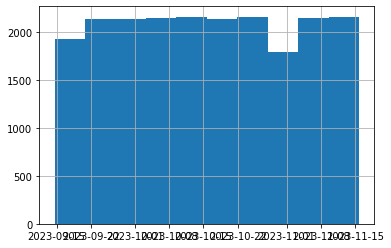

In [7]:
tournament_df["startsAt"].pipe(pd.to_datetime, unit="ms").hist()

In [8]:
tournament_df["nbPlayers"].describe()

count    20930.000000
mean       206.612136
std        230.014733
min          5.000000
25%         61.000000
50%        124.000000
75%        273.000000
max       2471.000000
Name: nbPlayers, dtype: float64

In [9]:
tournament_sample = tournament_df.loc[
    lambda df: (df["variant__key"] == "standard") & (df["nbPlayers"] > 350)
]

<Axes: >

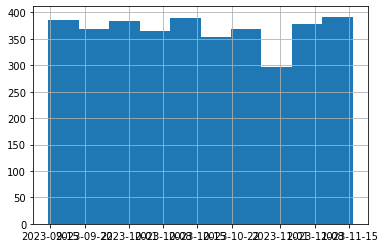

In [10]:
tournament_sample["startsAt"].pipe(pd.to_datetime, unit="ms").hist()

In [11]:
game_trepo = TableRepo(dz.get_raw_data_path("tournament-games.parquet"))
game_trepo.purge()

In [13]:
def extend_games(tour_k, pgn_string):
    meta_records = []
    for game_str in pgn_string.decode().strip().split("\n\n\n"):
        meta, moves = game_str.split("\n\n")

        meta_records.append(
            {"tournamentId": tour_k}
            | dict(re.findall('\[([a-z|A-Z]+) "(.*)"\]', meta))
            | dict(
                zip(
                    ["WhiteStart", "BlackStart", "WhiteM1", "BlackM1"],
                    re.findall("\[%clk ([\d|\:]+)\]", moves)[:4],
                )
            )
        )
    return meta_records
    #game_trepo.extend(pd.DataFrame(meta_records))

In [14]:
all_recs = []
for el in tqdm(dza.get_all_events(GetTournamentGames)):
    tour_id = el.url.split("/")[-2]
    if tour_id in tournament_sample.index:
        all_recs += extend_games(tour_id, el.content)


0it [00:00, ?it/s]

In [15]:
pd.DataFrame(all_recs).pipe(game_trepo.extend)

In [16]:
tournament_sample.to_parquet(dz.get_raw_data_path("tournament-sample.parquet"))